In [170]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import kagglehub
# import statsmodels.api as sm

# import tensorflow_addons as tfa
import cv2
from keras import backend as K

from sklearn.preprocessing import StandardScaler
import math
from sklearn.datasets import load_iris
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Input, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, Activation, Concatenate
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score
from keras.datasets import mnist
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import SparseCategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import GroupShuffleSplit


import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.get_logger().setLevel('ERROR')

import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from scipy.io import wavfile
from scipy.fftpack import fft
import cv2
import os
import librosa
import librosa.display
from glob import glob
import skimage
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from pydub import AudioSegment
from tqdm import tqdm
import tempfile

from tensorflow.keras import regularizers
tf.debugging.set_log_device_placement(False)

import numpy as np
import os
import re


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import tensorflow.keras.backend as K
from tensorflow.keras.metrics import Metric

# if os.path.isfile("myData.npz"):
if False:
    print("✅ 'data.npz' exists.")
    with np.load("myData.npz") as data:
        myData = data['myData']
        myData2 = data['myData2']
        myData3 = data['myData3']
        myY = data['myY']
        myActors = data['myActors']
        myDatasets = data['myDatasets']
        myHasNoise = data['myHasNoise']
        print(np.unique(myY))
        print(np.unique(myActors))
else:

    folder = './savefiles3'

    def findFilesFromPattern(pattern):
        pattern = re.compile(pattern + r'_(.*?)_(.*?)_(.*?)_(\d+)_(\d+)\.npy')
        heatmaps_dict = {}

        for filename in os.listdir(folder):
            match = pattern.match(filename)
            if match:
                dataset, actor, emotion, i, j = map(str, match.groups())
                i, j = int(i), int(j)
                filepath = os.path.join(folder, filename)
                data = np.load(filepath)

                heatmaps_dict[f'{dataset}_{actor}_{emotion}_{j // 2}_{j%2}'] = {'data': data, 'dataset': dataset, 'actor': actor, 'emotion':emotion, 'type': j, 'has_noise': (j%4 == 0 or j%4==1)}

        return heatmaps_dict

    mfccwasserstein = findFilesFromPattern('wassersteinMfccHeat')
    melwasserstein = findFilesFromPattern('wassersteinHeat')
    meltimeeuclid = findFilesFromPattern('timeMetricHeat')
    meleuclid = findFilesFromPattern('euclideanHeat')

    def load_spectrograms(prefixes, path='./savefiles'):
        patterns = []
        for prefix in prefixes:
            patterns.append(os.path.join(path, f"{prefix}_*.npy"))
        my_globs = glob(patterns[0])
        for pattern in patterns[1:]:
            my_globs = my_globs + glob(pattern)
        file_list = sorted(my_globs)
        return [np.load(file) for i, file in enumerate(file_list)]

    myRaw = load_spectrograms(["savee", 'tess', 'radvess', 'cremad'])
    print(len(mfccwasserstein))
    print(len([mfccwasserstein[key]['data'] for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0]))
    print(len([mfccwasserstein[key]['data'] for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 1]))
    print(np.array([[meleuclid[key]['data'] for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] == 0]]).shape)

    myRaw2 = load_spectrograms(["mfcc_savee", 'mfcc_tess', 'mfcc_radvess', 'mfcc_cremad'])

    print(len(myRaw2))
    print(len(myRaw2[0]))

    myData = np.array([myRaw])
    myData3 = np.stack([myRaw2])
    print('finish data')
    myData = myData.astype('float16')
    myData = np.transpose(myData, (1, 2, 3, 0))

    myData3 = myData3.astype('float16')
    myData3 = np.transpose(myData3, (1, 2, 3, 0))
    myEmotionMap = {
        'neutral': 1, 'calm':2, 'happy':3, 'sad':4, 'angry':5, 'fearful':6, 'disgust':7, 'surprised':8
    }
    myY = np.array(
        [myEmotionMap[meleuclid[key]['emotion']] -1 for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] % 2 == 0]
    )
    print(np.unique(myY))
    myActors = np.array(
        [meleuclid[key]['actor'] + '_' + meleuclid[key]['dataset']  for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] % 2 == 0]
    )
    myDatasets = np.array(
        [meleuclid[key]['dataset']  for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] % 2 == 0]
    )
    myHasNoise = np.array(
        [meleuclid[key]['has_noise']  for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] % 2 == 0]
    )
    print(np.unique(myActors))

    print(np.unique(myY))
    myY = [x -1 if x > 0 else x for x in myY]
    myY = to_categorical(myY, num_classes=6)

    myData2 = np.array([
                        [meleuclid[key]['data'] for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] % 2 == 0],
                        [meleuclid[key]['data'] for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] % 2 == 1],
                        [meltimeeuclid[key]['data'] for key in sorted(meltimeeuclid.keys()) if meltimeeuclid[key]['type'] % 2 == 0],
                        [meltimeeuclid[key]['data'] for key in sorted(meltimeeuclid.keys()) if meltimeeuclid[key]['type'] % 2 == 1],
                        # [mfccwasserstein[key]['data'] for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0],
                        # [mfccwasserstein[key]['data'] for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 1],
                        [melwasserstein[key]['data'] for key in sorted(melwasserstein.keys()) if melwasserstein[key]['type'] % 2 == 0],
                        [melwasserstein[key]['data'] for key in sorted(melwasserstein.keys()) if melwasserstein[key]['type'] % 2 == 1]
                        ])
    print('finish data')
    myData2 = myData2.astype('float16')
    print(myData2.shape)
    myData2 = np.transpose(myData2, (1, 2, 3, 0))
    print(myData2.shape)

    def upload_to_gcs(bucket_name, source_file, destination_blob):
        """Upload a file to a GCS bucket."""
        client = storage.Client()
        bucket = client.bucket(bucket_name)
        blob = bucket.blob(destination_blob)
        blob.upload_from_filename(source_file)
        print(f"✅ Uploaded {destination_blob} to gs://{bucket_name}/{destination_blob}")

    np.savez_compressed(
        "myData.npz",
        myData=myData,
        myData2=myData2,
        myData3=myData3,
        myY=myY,
        myActors=myActors,
        myDatasets=myDatasets,
        myHasNoise=myHasNoise
    )

    GCS_BUCKET = "simplicialcomplex-outputbucket"

    # upload_to_gcs(GCS_BUCKET, "myData.npz", "data/myData.npz")


22636
11318
11318
(1, 4, 64, 64)
11318
13
finish data
[0 2 3 4 5 6]
['01_radvess' '02_radvess' '03_radvess' '04_radvess' '05_radvess'
 '06_radvess' '07_radvess' '08_radvess' '09_radvess' '1001_cremad'
 '1002_cremad' '1003_cremad' '1004_cremad' '1005_cremad' '1006_cremad'
 '1007_cremad' '1008_cremad' '1009_cremad' '1010_cremad' '1011_cremad'
 '1012_cremad' '1013_cremad' '1014_cremad' '1015_cremad' '1016_cremad'
 '1017_cremad' '1018_cremad' '1019_cremad' '1020_cremad' '1021_cremad'
 '1022_cremad' '1023_cremad' '1024_cremad' '1025_cremad' '1026_cremad'
 '1027_cremad' '1028_cremad' '1029_cremad' '1030_cremad' '1031_cremad'
 '1032_cremad' '1033_cremad' '1034_cremad' '1035_cremad' '1036_cremad'
 '1037_cremad' '1038_cremad' '1039_cremad' '1040_cremad' '1041_cremad'
 '1042_cremad' '1043_cremad' '1044_cremad' '1045_cremad' '1046_cremad'
 '1047_cremad' '1048_cremad' '1049_cremad' '1050_cremad' '1051_cremad'
 '1052_cremad' '1053_cremad' '1054_cremad' '1055_cremad' '1056_cremad'
 '1057_cremad' '10

In [171]:
np.unique([meltimeeuclid[key]['data'].shape for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] % 2 == 0])

array([64])

In [172]:
# np.unique([str(x.shape) for x in myRaw2])

In [92]:
# myData = myData2
# myData3 = myData2

In [93]:
myData2.shape

(11318, 16, 16, 6)

In [94]:
myY.shape

(11318, 6)

In [143]:
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1)
groups = myActors#np.array([f"{d}_{a}_{c}" for d, a, c in zip(myActors, myDatasets)])

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import numpy as np

def stratified_group_split_3way(y, z, groups, val_size=0.2, test_size=0.2, random_state=42):
    rng = np.random.default_rng(random_state)
    df = pd.DataFrame({'y': y, 'z': z, 'group': groups})

    df["strat_label"] = df["y"].astype(str) + "_" + df["z"].astype(str)

    group_labels = (
        df.groupby('group')['y']
          .agg(lambda s: s.value_counts().index[0])
          .reset_index()
    )

    sss_outer = StratifiedShuffleSplit(
        n_splits=1, test_size=test_size, random_state=random_state
    )

    sss_inner = StratifiedShuffleSplit(
        n_splits=1, test_size=val_size/(1 - test_size), random_state=random_state + 1
    )

    group_indices = np.arange(len(group_labels))
    for trainval_g, test_g in sss_outer.split(group_indices, group_labels['y']):
        trainval_groups = group_labels['group'].iloc[trainval_g].values
        test_groups = group_labels['group'].iloc[test_g].values

        trainval_df = group_labels.iloc[trainval_g]
        trainval_idx = np.arange(len(trainval_df))

        for train_g, val_g in sss_inner.split(trainval_idx, trainval_df['y']):
            train_groups = trainval_df['group'].iloc[train_g].values
            val_groups = trainval_df['group'].iloc[val_g].values

    # Map back to samples
    train_mask = df['group'].isin(train_groups)
    val_mask = df['group'].isin(val_groups)
    test_mask = df['group'].isin(test_groups)

    train_idx = np.where(train_mask)[0]
    val_idx = np.where(val_mask)[0]
    test_idx = np.where(test_mask)[0]

    return train_idx, val_idx, test_idx

def stratified_group_split_cover_z_3way(
    y,
    z,
    groups,
    val_size=0.2,
    test_size=0.2,
    random_state=50,
    keep_size=True,
):
    """
    3-way group-wise split (train/val/test) with:
      - stratification by composite (y,z)
      - at least one of each z in test
      - no group overlap between splits

    Parameters
    ----------
    y : array-like
        Primary labels (e.g. emotion IDs)
    z : array-like
        Secondary variable (e.g. gender, dataset)
    groups : array-like
        Group IDs (e.g. actors)
    val_size : float
        Fraction of remaining groups for validation (after test split)
    test_size : float
        Fraction of all groups for test
    random_state : int
        RNG seed
    keep_size : bool
        Try to maintain split sizes even when adding missing z-groups
    """
    rng = np.random.default_rng(random_state)
    df = pd.DataFrame({"y": y, "z": z, "group": groups})

    # Composite stratification label
    df["strat"] = df["y"].astype(str) + "_" + df["z"].astype(str)

    # Majority composite per group
    grp = (
        df.groupby("group")["y"]
          .agg(lambda s: s.value_counts().index[0])
          .reset_index()
    )

    # --- Step 1: TrainVal/Test Split ---
    sss_outer = StratifiedShuffleSplit(
        n_splits=1, test_size=test_size, random_state=random_state
    )
    g_idx = np.arange(len(grp))
    for trainval_g_idx, test_g_idx in sss_outer.split(g_idx, grp["y"]):
        trainval_groups = set(grp["group"].iloc[trainval_g_idx])
        test_groups = set(grp["group"].iloc[test_g_idx])

    # --- Ensure all z categories appear in test ---
    all_z = set(df["z"].unique())
    def z_in_groups(gset):
        return set(df[df["group"].isin(gset)]["z"].unique())

    test_z = z_in_groups(test_groups)
    missing_z = list(all_z - test_z)

    if missing_z:
        g2count = df.groupby("group").size().to_dict()
        z_to_groups = {zv: set(df.loc[df["z"] == zv, "group"].unique()) for zv in all_z}

        for zv in missing_z:
            candidates = z_to_groups[zv] & trainval_groups
            if not candidates:
                continue
            g_chosen = min(candidates, key=lambda g: g2count.get(g, 0))
            trainval_groups.remove(g_chosen)
            test_groups.add(g_chosen)

            if keep_size:
                removable = []
                test_z_after = z_in_groups(test_groups)
                for g in list(test_groups - {g_chosen}):
                    tmp = test_groups.copy()
                    tmp.remove(g)
                    if z_in_groups(tmp) == test_z_after:
                        removable.append(g)
                if removable:
                    g_back = max(removable, key=lambda g: g2count.get(g, 0))
                    test_groups.remove(g_back)
                    trainval_groups.add(g_back)

    # --- Step 2: Train/Val Split (from remaining groups) ---
    subgrp = (
        df[df["group"].isin(trainval_groups)]
        .groupby("group")["y"]
        .agg(lambda s: s.value_counts().index[0])
        .reset_index()
    )

    sss_inner = StratifiedShuffleSplit(
        n_splits=1,
        test_size=val_size / (1 - test_size),
        random_state=random_state + 1,
    )
    g_idx_inner = np.arange(len(subgrp))
    for train_g_idx, val_g_idx in sss_inner.split(g_idx_inner, subgrp["y"]):
        train_groups = set(subgrp["group"].iloc[train_g_idx])
        val_groups = set(subgrp["group"].iloc[val_g_idx])

    # --- Map groups to sample indices ---
    train_idx = np.where(df["group"].isin(train_groups))[0]
    val_idx   = np.where(df["group"].isin(val_groups))[0]
    test_idx  = np.where(df["group"].isin(test_groups))[0]

    return train_idx, val_idx, test_idx




train_idx, val_idx, test_idx = stratified_group_split_3way(y=np.argmax(myY, axis=1), z=myDatasets, groups=groups, val_size=0.2, test_size=0.2)
# train_val_idx = np.where((myDatasets == 'cremad') | (myDatasets == 'tess') | (myDatasets == 'savee'))[0]
# test_idx = np.where(myDatasets == 'radvess')[0]

# train_val_idx = np.where((myHasNoise == 0))[0]
# test_idx = np.where(myHasNoise == 1)[0]



# train_val_idx, test_idx = train_test_split(
#     np.arange(len(myY)), test_size=0.2, random_state=42, shuffle=True
# )

# # # Then split train/val
# train_idx, val_idx = train_test_split(
#     train_val_idx, test_size=0.2, random_state=42, shuffle=True
# )

X_train, X_val, X_test, X_train2, X_val2, X_test2, X_train3, X_val3, X_test3 = myData[train_idx], myData[val_idx], myData[test_idx], myData2[train_idx], myData2[val_idx], myData2[test_idx], myData3[train_idx], myData3[val_idx], myData3[test_idx]
y_train, y_val, y_test = myY[train_idx], myY[val_idx], myY[test_idx]


print(X_train.shape)
has_noise_idx = np.where((myHasNoise[train_idx] == 0) | (myHasNoise[train_idx] == 1))[0]
X_train_tensor = torch.tensor(X_train[has_noise_idx].transpose(0, 3, 1, 2), dtype=torch.float32)
X_train2_tensor = torch.tensor(X_train2[has_noise_idx].transpose(0, 3, 1, 2), dtype=torch.float32)
X_train3_tensor = torch.tensor(X_train3[has_noise_idx].transpose(0, 3, 1, 2), dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train[has_noise_idx], axis=1), dtype=torch.long)

has_noise_idx = np.where((myHasNoise[val_idx] == 0) | (myHasNoise[val_idx] == 1))[0]
X_val_tensor = torch.tensor(X_val[has_noise_idx].transpose(0, 3, 1, 2), dtype=torch.float32)
X_val2_tensor = torch.tensor(X_val2[has_noise_idx].transpose(0, 3, 1, 2), dtype=torch.float32)
X_val3_tensor = torch.tensor(X_val3[has_noise_idx].transpose(0, 3, 1, 2), dtype=torch.float32)
y_val_tensor = torch.tensor(np.argmax(y_val[has_noise_idx], axis=1), dtype=torch.long)

has_noise_idx = np.where((myHasNoise[test_idx] == 0))[0]
X_test_tensor = torch.tensor(X_test[has_noise_idx].transpose(0, 3, 1, 2), dtype=torch.float32)
X_test2_tensor = torch.tensor(X_test2[has_noise_idx].transpose(0, 3, 1, 2), dtype=torch.float32)
X_test3_tensor = torch.tensor(X_test3[has_noise_idx].transpose(0, 3, 1, 2), dtype=torch.float32)
y_test_tensor = torch.tensor(np.argmax(y_test[has_noise_idx], axis=1), dtype=torch.long)


(7836, 128, 256, 1)


In [144]:


class CNNModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),  # for input 32×32 after two poolings
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class CNNModel2(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = CNNModel(64)
        self.model2 = CNNModel2(64)
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )
    def forward(self, x1, x2):
        x1 = self.model(x1)
        x2 = self.model2(x2)
        x = torch.cat([x1, x2], dim=1)
        return self.classifier(x)

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple GPU
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU (if any)
else:
    device = torch.device("cpu")   # fallback

auroc = MulticlassAUROC(num_classes=6, average='macro').to(device)
top3acc = MulticlassAccuracy(num_classes=6, top_k=3).to(device)

In [63]:
np.unique(myActors[train_idx])

array(['01_radvess', '04_radvess', '06_radvess', '1001_cremad',
       '1002_cremad', '1003_cremad', '1004_cremad', '1005_cremad',
       '1006_cremad', '1007_cremad', '1009_cremad', '1010_cremad',
       '1011_cremad', '1014_cremad', '1016_cremad', '1017_cremad',
       '1020_cremad', '1022_cremad', '1023_cremad', '1024_cremad',
       '1028_cremad', '1031_cremad', '1032_cremad', '1033_cremad',
       '1034_cremad', '1035_cremad', '1037_cremad', '1038_cremad',
       '1040_cremad', '1041_cremad', '1043_cremad', '1045_cremad',
       '1046_cremad', '1047_cremad', '1048_cremad', '1050_cremad',
       '1053_cremad', '1054_cremad', '1056_cremad', '1057_cremad',
       '1058_cremad', '1059_cremad', '1060_cremad', '1061_cremad',
       '1062_cremad', '1064_cremad', '1065_cremad', '1067_cremad',
       '1070_cremad', '1072_cremad', '1073_cremad', '1075_cremad',
       '1076_cremad', '1080_cremad', '1081_cremad', '1082_cremad',
       '1083_cremad', '1084_cremad', '1085_cremad', '1086_cremad'

In [64]:
np.unique(myActors[test_idx])

array(['02_radvess', '03_radvess', '1012_cremad', '1013_cremad',
       '1015_cremad', '1021_cremad', '1029_cremad', '1044_cremad',
       '1051_cremad', '1052_cremad', '1055_cremad', '1063_cremad',
       '1066_cremad', '1074_cremad', '1078_cremad', '1079_cremad',
       '1091_cremad', '10_radvess', '12_radvess', '13_radvess',
       '16_radvess', '17_radvess', '19_radvess', '23_radvess', 'JK_savee'],
      dtype='<U11')

In [65]:
np.unique(myActors[val_idx])

array(['05_radvess', '07_radvess', '08_radvess', '09_radvess',
       '1008_cremad', '1018_cremad', '1019_cremad', '1025_cremad',
       '1026_cremad', '1027_cremad', '1030_cremad', '1036_cremad',
       '1039_cremad', '1042_cremad', '1049_cremad', '1068_cremad',
       '1069_cremad', '1071_cremad', '1077_cremad', '1087_cremad',
       '1090_cremad', '18_radvess', '22_radvess', 'KL_savee'],
      dtype='<U11')

In [44]:
np.unique(y_train)

array([0., 1.])

In [28]:

# --- Instantiate model ---
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


dataset = TensorDataset(X_train_tensor, X_train2_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, X_val2_tensor, y_val_tensor)

train_loader = DataLoader(dataset, batch_size=256, shuffle=True,
                          num_workers=4,
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=256,num_workers=4,
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, X_test2_tensor, y_test_tensor), batch_size=256)



# model = CNNModel().to(device)
# model2 = CNNModel2().to(device)


# fusion = FusionNetGated().to(device)

model_comb = CombinedModel(num_classes=6).to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3, weight_decay=1e-4)
# fusion_optimizer = torch.optim.Adam(fusion.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer_combined = torch.optim.Adam(model_comb.parameters())
num_epochs = 30

best_val_auc = 0


# ================================================================
# Training Loop with Checkpoint
# ================================================================
for epoch in range(num_epochs):
    model_comb.train()
    train_preds, train_labels = [], []
    for X_batch, X2_batch, y_batch in train_loader:
        X_batch, X2_batch, y_batch = X_batch.to(device), X2_batch.to(device), y_batch.to(device)
        # optimizer.zero_grad()
        # optimizer2.zero_grad()
        # fusion_optimizer.zero_grad()
        optimizer_combined.zero_grad()

        # outputs = model(X_batch)
        # outputs2 = model2(X2_batch)

        # combined_logits, alpha = fusion(outputs, outputs2)
        combined_logits = model_comb(X_batch, X2_batch)
        loss = criterion(combined_logits, y_batch)

        # optional deep supervision helps
        # loss = loss + 0.2*criterion(outputs, y_batch) + 0.2*criterion(outputs2, y_batch)
        loss.backward()

        train_preds.append(torch.softmax(combined_logits, dim=1))
        train_labels.append(y_batch)

        # optimizer.step()

        # optimizer2.step()

        # fusion_optimizer.step()

        optimizer_combined.step()

    # Validation
    model_comb.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for X_val, X2_val, y_val in val_loader:
            X_val, X2_val, y_val = X_val.to(device), X2_val.to(device), y_val.to(device)
            # outputs = model(X_val)
            # outputs2 = model2(X2_val)

            # combined_logits = fusion(outputs, outputs2)
            # combined_logits, alpha = fusion(outputs, outputs2)

            combined_logits = model_comb(X_val, X2_val)
            # loss = criterion(combined_logits, y_val)

            val_loss = criterion(combined_logits, y_val)
            preds = torch.softmax(combined_logits, dim=1)
            val_preds.append(preds)
            val_labels.append(y_val)
    val_preds = torch.cat(val_preds)
    val_labels = torch.cat(val_labels)

    val_auc = auroc(val_preds, val_labels).item()
    val_top3 = top3acc(val_preds, val_labels).item()

    y_pred = torch.argmax(val_preds, dim=1)

    accuracy = (y_pred == val_labels).float().mean()

    print(f"Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f} - top3_acc: {val_top3:.4f} - val_acc: {accuracy.item():.4f} - val_loss {val_loss.item():.4f}")

    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        # torch.save(model.state_dict(), "best_model_full.pth")
        # torch.save(model2.state_dict(), "best_model_full2.pth")
        # torch.save(fusion.state_dict(), "best_model_full3.pth")
        torch.save(model_comb.state_dict(), "best_model_comb.pth")
        print("✅ Saved new best model.")

    train_preds = torch.cat(train_preds)
    train_labels = torch.cat(train_labels)
    val_auc = auroc(train_preds, train_labels).item()
    val_top3 = top3acc(train_preds, train_labels).item()

    y_pred = torch.argmax(train_preds, dim=1)

    accuracy = (y_pred == train_labels).float().mean()
    print(f"Epoch {epoch+1}/{num_epochs} - train_auc: {val_auc:.4f} - train_top3_acc: {val_top3:.4f} - train_acc: {accuracy.item():.4f} - train_loss: {loss.item():.4f}")


Using device: mps
Epoch 1/30 - val_auc: 0.6964 - top3_acc: 0.6434 - val_acc: 0.2716 - val_loss 2.4666
✅ Saved new best model.
Epoch 1/30 - train_auc: 0.7199 - train_top3_acc: 0.7417 - train_acc: 0.3388 - train_loss: 1.3842
Epoch 2/30 - val_auc: 0.6687 - top3_acc: 0.5332 - val_acc: 0.2162 - val_loss 2.3483
Epoch 2/30 - train_auc: 0.8447 - train_top3_acc: 0.8631 - train_acc: 0.5193 - train_loss: 0.9945
Epoch 3/30 - val_auc: 0.7242 - top3_acc: 0.6096 - val_acc: 0.2836 - val_loss 3.7964
✅ Saved new best model.
Epoch 3/30 - train_auc: 0.8895 - train_top3_acc: 0.8936 - train_acc: 0.6053 - train_loss: 0.9203
Epoch 4/30 - val_auc: 0.7852 - top3_acc: 0.7965 - val_acc: 0.3735 - val_loss 2.0746
✅ Saved new best model.
Epoch 4/30 - train_auc: 0.9113 - train_top3_acc: 0.9083 - train_acc: 0.6473 - train_loss: 0.8179
Epoch 5/30 - val_auc: 0.7119 - top3_acc: 0.5305 - val_acc: 0.2967 - val_loss 6.7574
Epoch 5/30 - train_auc: 0.9229 - train_top3_acc: 0.9211 - train_acc: 0.6729 - train_loss: 0.8751
Epoch

Epoch 30/30 - val_auc: 0.8323 - top3_acc: 0.8560 - val_acc: 0.4945
              precision    recall  f1-score   support

     neutral       0.67      0.32      0.43       246
       happy       0.52      0.30      0.38       297
         sad       0.45      0.46      0.46       297
       angry       0.61      0.70      0.65       297
     fearful       0.39      0.72      0.51       297
     disgust       0.52      0.44      0.48       297

    accuracy                           0.49      1731
   macro avg       0.53      0.49      0.48      1731
weighted avg       0.52      0.49      0.49      1731



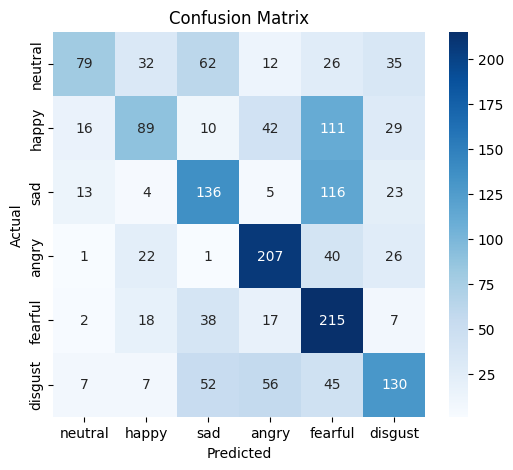

In [29]:


model_comb.load_state_dict(torch.load("best_model_comb.pth"))
model_comb.eval()

all_preds, all_labels, all_preds2, all_labels2 = [], [], [], []
with torch.no_grad():
    for X_batch, X2_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        X2_batch = X2_batch.to(device)
        combined_logits = model_comb(X_batch, X2_batch)
        preds = torch.argmax(combined_logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_preds2.append(torch.softmax(combined_logits, dim=1))
        all_labels.extend(y_batch.numpy())
        all_labels2.append(y_batch.to(device))

    val_preds = torch.cat(all_preds2)
    val_labels = torch.cat(all_labels2)
    val_auc = auroc(val_preds, val_labels).item()
    val_top3 = top3acc(val_preds, val_labels).item()

    y_pred = torch.argmax(val_preds, dim=1)

    accuracy = (y_pred == val_labels).float().mean()

    print(f"Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f} - top3_acc: {val_top3:.4f} - val_acc: {accuracy.item():.4f}")

# Classification report
class_labels = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']
report = classification_report(all_labels, all_preds, target_names=class_labels)
print(report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [12]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),  # for input 32×32 after two poolings
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),  # for input 32×32 after two poolings
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [13]:

dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(dataset, batch_size=256, shuffle=True,
                          num_workers=4,
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=256,num_workers=4,
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=256)

model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 20

best_val_auc = 0.0

# ================================================================
# Training Loop with Checkpoint
# ================================================================
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            preds = torch.softmax(outputs, dim=1)
            val_preds.append(preds)
            val_labels.append(y_val)
    val_preds = torch.cat(val_preds)
    val_labels = torch.cat(val_labels)

    val_auc = auroc(val_preds, val_labels).item()
    val_top3 = top3acc(val_preds, val_labels).item()

    y_pred = torch.argmax(val_preds, dim=1)

    accuracy = (y_pred == val_labels).float().mean()

    print(f"Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f} - top3_acc: {val_top3:.4f} - val_acc: {accuracy.item():.4f}")

    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), "best_model_mel.pth")
        print("✅ Saved new best model.")


Epoch 1/20 - val_auc: 0.7942 - top3_acc: 0.7410 - val_acc: 0.3631
✅ Saved new best model.
Epoch 2/20 - val_auc: 0.8588 - top3_acc: 0.8269 - val_acc: 0.5017
✅ Saved new best model.
Epoch 3/20 - val_auc: 0.9024 - top3_acc: 0.8894 - val_acc: 0.6143
✅ Saved new best model.
Epoch 4/20 - val_auc: 0.8885 - top3_acc: 0.8374 - val_acc: 0.5433
Epoch 5/20 - val_auc: 0.9186 - top3_acc: 0.9074 - val_acc: 0.6358
✅ Saved new best model.
Epoch 6/20 - val_auc: 0.9145 - top3_acc: 0.9062 - val_acc: 0.6198
Epoch 7/20 - val_auc: 0.9021 - top3_acc: 0.8623 - val_acc: 0.5930
Epoch 8/20 - val_auc: 0.8761 - top3_acc: 0.8568 - val_acc: 0.4967
Epoch 9/20 - val_auc: 0.9174 - top3_acc: 0.8732 - val_acc: 0.6013
Epoch 10/20 - val_auc: 0.8412 - top3_acc: 0.7715 - val_acc: 0.4611
Epoch 11/20 - val_auc: 0.8711 - top3_acc: 0.7826 - val_acc: 0.4702
Epoch 12/20 - val_auc: 0.9163 - top3_acc: 0.9133 - val_acc: 0.6237
Epoch 13/20 - val_auc: 0.8979 - top3_acc: 0.8701 - val_acc: 0.5345
Epoch 14/20 - val_auc: 0.9324 - top3_acc: 

Epoch 20/20 - val_auc: 0.9426 - top3_acc: 0.9298 - val_acc: 0.7086
              precision    recall  f1-score   support

     neutral       0.65      0.83      0.73       348
       happy       0.70      0.78      0.74       394
         sad       0.76      0.50      0.61       352
       angry       0.64      0.92      0.75       360
     fearful       0.79      0.58      0.67       368
     disgust       0.80      0.65      0.72       412

    accuracy                           0.71      2234
   macro avg       0.72      0.71      0.70      2234
weighted avg       0.73      0.71      0.70      2234



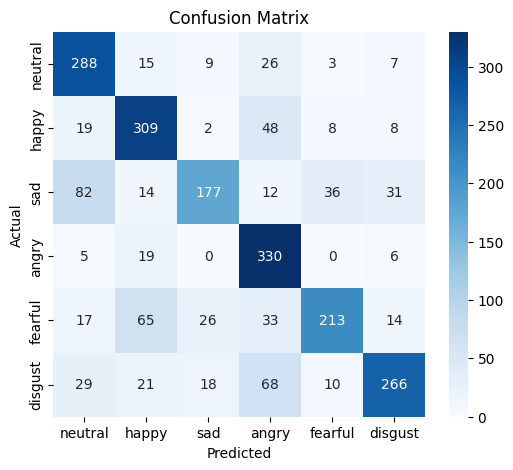

In [14]:

# ================================================================
# Evaluation
# ================================================================
model.load_state_dict(torch.load("best_model_mel.pth"))
model.eval()

all_preds, all_labels, all_preds2, all_labels2 = [], [], [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_preds2.append(torch.softmax(outputs, dim=1))
        all_labels.extend(y_batch.numpy())
        all_labels2.append(y_batch.to(device))

    val_preds = torch.cat(all_preds2)
    val_labels = torch.cat(all_labels2)
    val_auc = auroc(val_preds, val_labels).item()
    val_top3 = top3acc(val_preds, val_labels).item()

    y_pred = torch.argmax(val_preds, dim=1)

    accuracy = (y_pred == val_labels).float().mean()

    print(f"Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f} - top3_acc: {val_top3:.4f} - val_acc: {accuracy.item():.4f}")


# Classification report
class_labels = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']
report = classification_report(all_labels, all_preds, target_names=class_labels)
print(report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [173]:
class CNNModel2(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(6, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, return_embedding: bool = False):
        f = self.features(x)
        z = self.classifier[:-1](f)      # <- 64-dim embedding after ReLU+Dropout
        logits = self.classifier[-1](z)  # final linear to classes
        return z if return_embedding else logits

In [174]:
X_train2_tensor.shape

torch.Size([7836, 6, 32, 32])

In [175]:
X_train2[:,:,:,0].shape

(7836, 32, 32)

In [150]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score


# X = flattened persistence images (N, 1024)
kmeans = KMeans(n_clusters=6, random_state=42)
labels_unsup = kmeans.fit_predict(X_train2)
ari = adjusted_rand_score(y_train, labels_unsup)
print("ARI:", ari)


ValueError: Found array with dim 4. KMeans expected <= 2.

In [176]:

dataset = TensorDataset(X_train2_tensor, y_train_tensor)
val_ds = TensorDataset(X_val2_tensor, y_val_tensor)

train_loader = DataLoader(dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256)
test_loader = DataLoader(TensorDataset(X_test2_tensor, y_test_tensor), batch_size=256)

model = CNNModel2().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 40

best_val_auc = 0.0

# ================================================================
# Training Loop with Checkpoint
# ================================================================
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            preds = torch.softmax(outputs, dim=1)
            val_preds.append(preds)
            val_labels.append(y_val)
    val_preds = torch.cat(val_preds)
    val_labels = torch.cat(val_labels)

    val_auc = auroc(val_preds, val_labels).item()
    val_top3 = top3acc(val_preds, val_labels).item()

    y_pred = torch.argmax(val_preds, dim=1)

    accuracy = (y_pred == val_labels).float().mean()

    print(f"Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f} - top3_acc: {val_top3:.4f} - val_acc: {accuracy.item():.4f}")

    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), "best_model_per.pth")
        print("✅ Saved new best model.")


Epoch 1/40 - val_auc: 0.6568 - top3_acc: 0.5679 - val_acc: 0.2496
✅ Saved new best model.
Epoch 2/40 - val_auc: 0.7041 - top3_acc: 0.7432 - val_acc: 0.3238
✅ Saved new best model.
Epoch 3/40 - val_auc: 0.7042 - top3_acc: 0.7120 - val_acc: 0.3038
✅ Saved new best model.
Epoch 4/40 - val_auc: 0.7250 - top3_acc: 0.7668 - val_acc: 0.3312
✅ Saved new best model.
Epoch 5/40 - val_auc: 0.7253 - top3_acc: 0.7414 - val_acc: 0.3341
✅ Saved new best model.
Epoch 6/40 - val_auc: 0.7366 - top3_acc: 0.7955 - val_acc: 0.3632
✅ Saved new best model.
Epoch 7/40 - val_auc: 0.7359 - top3_acc: 0.7828 - val_acc: 0.3632
Epoch 8/40 - val_auc: 0.7321 - top3_acc: 0.7665 - val_acc: 0.3598
Epoch 9/40 - val_auc: 0.7329 - top3_acc: 0.7450 - val_acc: 0.3478
Epoch 10/40 - val_auc: 0.7412 - top3_acc: 0.7685 - val_acc: 0.3541
✅ Saved new best model.
Epoch 11/40 - val_auc: 0.7360 - top3_acc: 0.7738 - val_acc: 0.3706
Epoch 12/40 - val_auc: 0.7445 - top3_acc: 0.7978 - val_acc: 0.3826
✅ Saved new best model.
Epoch 13/40 -

Epoch 40/40 - val_auc: 0.7372 - top3_acc: 0.7679 - val_acc: 0.3525
              precision    recall  f1-score   support

     neutral       0.45      0.26      0.33       117
       happy       0.30      0.15      0.20       137
         sad       0.45      0.57      0.50       143
       angry       0.31      0.76      0.44       140
     fearful       0.37      0.13      0.19       152
     disgust       0.30      0.24      0.27       145

    accuracy                           0.35       834
   macro avg       0.36      0.35      0.32       834
weighted avg       0.36      0.35      0.32       834



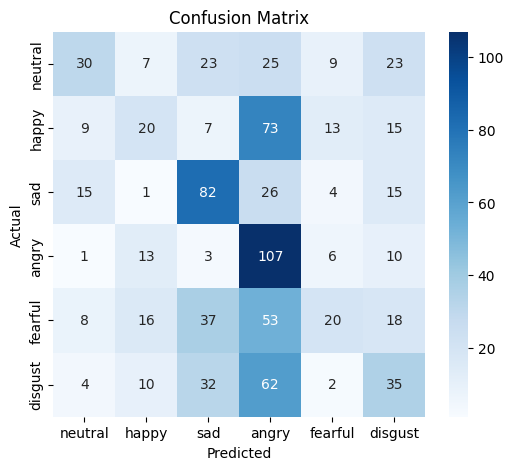

In [177]:

# ================================================================
# Evaluation
# ================================================================
model.load_state_dict(torch.load("best_model_per.pth"))
model.eval()

all_preds, all_labels, all_preds2, all_labels2 = [], [], [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_preds2.append(torch.softmax(outputs, dim=1))
        all_labels.extend(y_batch.numpy())
        all_labels2.append(y_batch.to(device))

    val_preds = torch.cat(all_preds2)
    val_labels = torch.cat(all_labels2)
    val_auc = auroc(val_preds, val_labels).item()
    val_top3 = top3acc(val_preds, val_labels).item()

    y_pred = torch.argmax(val_preds, dim=1)

    accuracy = (y_pred == val_labels).float().mean()

    print(f"Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f} - top3_acc: {val_top3:.4f} - val_acc: {accuracy.item():.4f}")


# Classification report
class_labels = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']
report = classification_report(all_labels, all_preds, target_names=class_labels)
print(report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [156]:
import numpy as np
from sklearn.cluster import KMeans

# X2: (N, 2)  -> e.g., from PCA/UMAP/t-SNE
# choose k (6 emotions -> k=6)
k = 6
km = KMeans(n_clusters=k, n_init=10, random_state=42)
labels_km = km.fit_predict(X2)     # cluster ids (0..k-1)
centers = km.cluster_centers_      # (k, 2)


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# X_imgs: (N, 16, 16)
X = X_train2.reshape(len(X_train2), -1)          # (N, 256)

# Standardize features (zero mean/unit var)
Xz = StandardScaler().fit_transform(X)

# Optional but helpful: reduce to 20–50 dims to denoise
pca = PCA(n_components=32, random_state=42)
Xp = pca.fit_transform(Xz)

# Optional: cosine-friendly (spherical) k-means approximation
Xp_norm = normalize(Xp)   # L2-normalize rows

k = 6  # number of clusters (e.g., emotions)
km = KMeans(n_clusters=k, n_init=20, random_state=42)
labels_km = km.fit_predict(Xp_norm)

print("Silhouette:", silhouette_score(Xp_norm, labels_km))
# If you have ground-truth labels y_true (N,):


Silhouette: 0.17408503006051443


In [137]:
print("ARI:", adjusted_rand_score(y_train_tensor, labels_km))
print("NMI:", normalized_mutual_info_score(y_train_tensor, labels_km))


ARI: 0.0489866188701577
NMI: 0.07722641755663259


In [157]:
import matplotlib.pyplot as plt

centers = km.cluster_centers_              # (k, 32) because of PCA
centers_256 = pca.inverse_transform(centers)   # back to 256-dim
# centers_img = StandardScaler().inverse_transform(centers_256) # undo z-score if desired
centers_img = centers_img.reshape(k, 16, 16)

fig, axes = plt.subplots(1, k, figsize=(2.8*k, 2.6))
for i, ax in enumerate(axes):
    ax.imshow(centers_img[i], cmap="viridis")
    ax.set_title(f"C{i}"); ax.axis('off')
plt.tight_layout(); plt.show()


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 32 is different from 2)

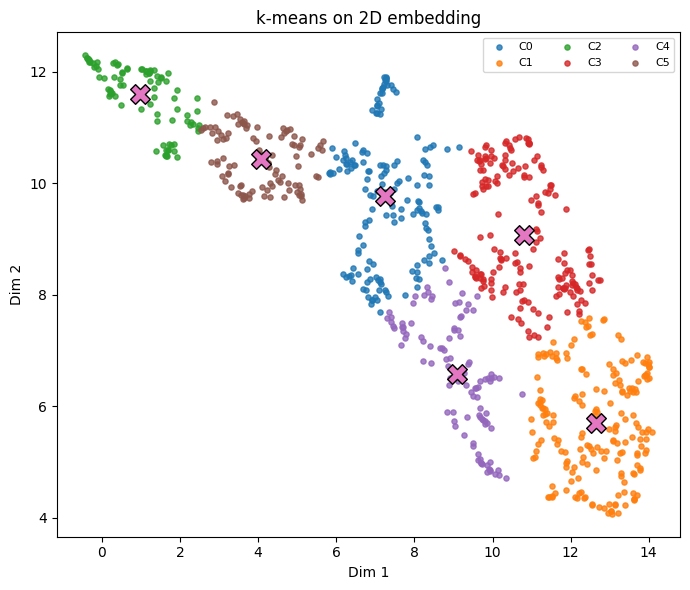

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
for cid in range(k):
    mask = labels_km == cid
    plt.scatter(X2[mask,0], X2[mask,1], s=14, alpha=0.8, label=f"C{cid}")
plt.scatter(centers[:,0], centers[:,1], s=200, marker="X", edgecolor="k", linewidths=1.0)
plt.title("k-means on 2D embedding"); plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.legend(ncol=3, fontsize=8); plt.tight_layout(); plt.show()


In [159]:
# y_true: ground-truth emotion ids (N,)
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

print("ARI:", adjusted_rand_score(y_test_tensor, labels_km))
print("NMI:", normalized_mutual_info_score(y_test_tensor, labels_km))
print("Silhouette (uses X2 only):", silhouette_score(X2, labels_km))


ARI: 0.06209902051889338
NMI: 0.1102694401735232
Silhouette (uses X2 only): 0.4514636


In [141]:
y_test_tensor

tensor([3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5,
        4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5,
        5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5,
        5, 5, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
        2, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2,

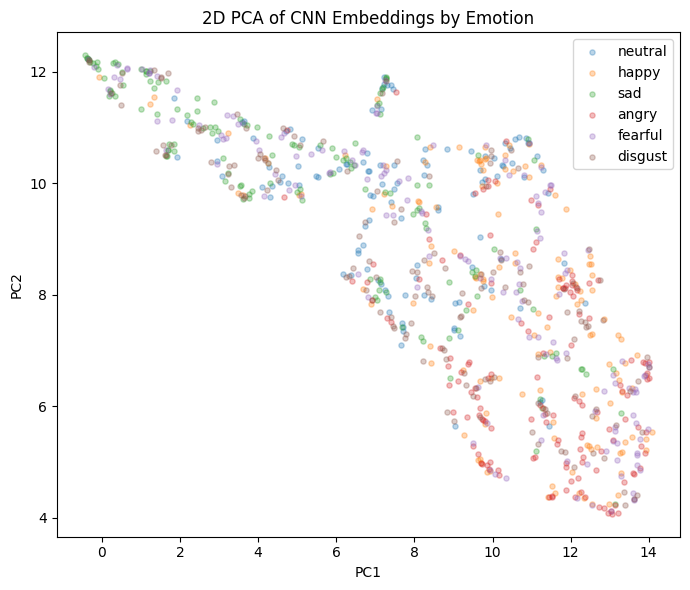

In [151]:
import numpy as np
import torch

model.eval()
embs, labs = [], []
with torch.no_grad():
    for xb, yb in test_loader:  # your DataLoader
        xb = xb.to(next(model.parameters()).device)
        z = model(xb, return_embedding=True)   # (B, 64)
        embs.append(z.cpu().numpy())
        labs.append(yb.numpy())

X = np.concatenate(embs, axis=0)
y = np.concatenate(labs, axis=0)

# ---- 2D projection (PCA or t-SNE or UMAP) ----
import umap.umap_ as umap
X2 = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1).fit_transform(X)

# ---- Plot ----
import matplotlib.pyplot as plt
classes = ['neutral','happy','sad','angry','fearful','disgust']  # adjust order if needed
plt.figure(figsize=(7,6))
for c, name in enumerate(classes):
    mask = (y == c)
    plt.scatter(X2[mask,0], X2[mask,1], s=14, label=name, alpha=0.3)
plt.title("2D PCA of CNN Embeddings by Emotion")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.tight_layout(); plt.show()


In [152]:
from captum.attr import Occlusion
import torch

x = xb[:1].to(device)                    # x: (1, 6, 32, 32)
target = int(yb[0])

occ = Occlusion(model)

attr_occ = occ.attribute(
    x,
    target=target,
    sliding_window_shapes=(1, 8, 8),   # 1 channel, 8x8 patch
    strides=(1, 4, 4),                 # slide along channels & space
    baselines=0,
)
# You can inspect each channel’s heatmap separately, or average them.
attr_occ_2d = attr_occ.abs().mean(dim=1, keepdim=False)[0].cpu().numpy()


In [153]:
yb[10]

tensor(3)

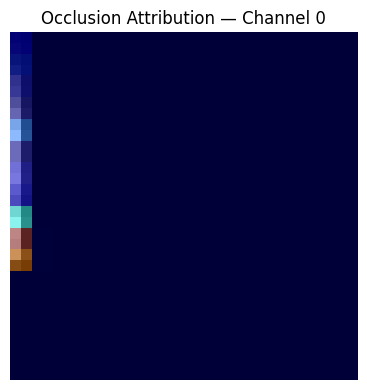

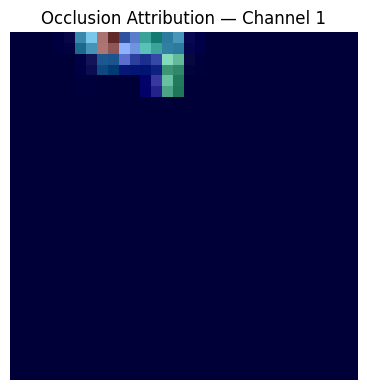

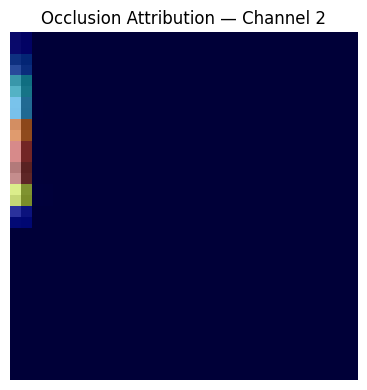

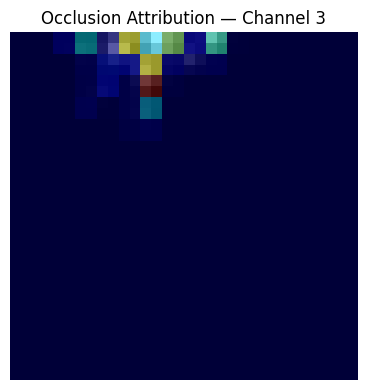

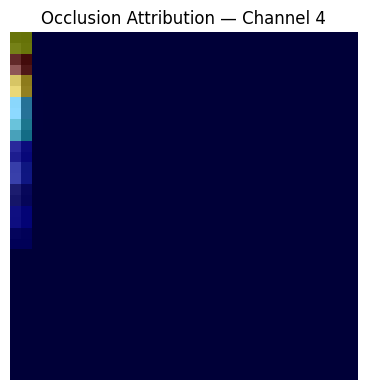

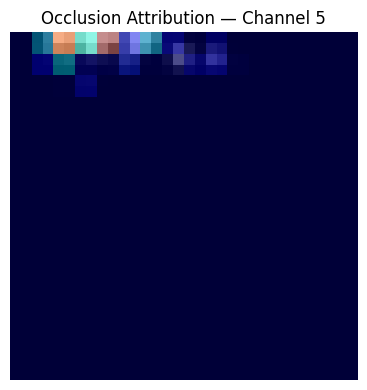

Channel 0: mean |occlusion attr| = 0.000497
Channel 1: mean |occlusion attr| = 0.000080
Channel 2: mean |occlusion attr| = 0.026744
Channel 3: mean |occlusion attr| = 0.004422
Channel 4: mean |occlusion attr| = 0.006443
Channel 5: mean |occlusion attr| = 0.003927


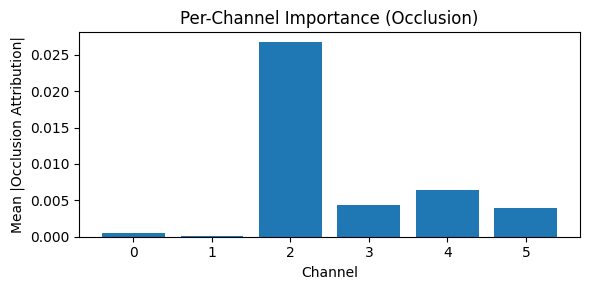

In [ ]:
# --- Setup ---
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import Occlusion

model.eval()
device = next(model.parameters()).device

# x: a single sample with shape (1, 6, 32, 32)
# y: its label (int)
index = 20
x = xb[index:index+1].to(device)          # adjust to your tensor name
target = int(yb[index])            # class index for the example

# --- Occlusion per channel ---
occ = Occlusion(model)

# Choose patch/stride (spatial)
patch  = 4
stride = 4

# Store per-channel heatmaps
attr_per_ch = []   # list of (H, W) numpy arrays

for c in range(x.shape[1]):  # 6 channels
    # Create a mask that occludes only 1 channel at a time
    # sliding_window_shapes and strides are (C, H, W), length = 3
    attr = occ.attribute(
        x,
        target=target,
        sliding_window_shapes=(1, patch, patch),   # one channel, patch x patch
        strides=(1, stride, stride),               # slide across that channel & space
        baselines=0,
        # Use additional_forward_args if your forward() needs extra args
    )
    # Keep only this channel’s attribution (attr has shape (1,6,H,W))
    # Zero out others so we can isolate channel c
    attr_c = attr[:, c:c+1, :, :]                 # (1,1,H,W)
    # Reduce to 2D heatmap for plotting
    heat = attr_c.abs().mean(dim=1, keepdim=False)[0].detach().cpu().numpy()  # (H, W)
    attr_per_ch.append(heat)

# --- Helper: overlay function ---
def show_overlay(base_2d, heat_2d, title=None, save_path=None):
    # min-max normalize heat for display
    h = (heat_2d - heat_2d.min()) / (heat_2d.max() - heat_2d.min() + 1e-8)
    plt.figure(figsize=(5,4))
    plt.imshow(base_2d, cmap='gray')
    plt.imshow(h, cmap='jet', alpha=0.45)
    if title: plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# --- Plot & save each channel’s overlay ---
# Use each channel itself as the grayscale backdrop so it’s truly "per-heatmap"
x_np = x[0].detach().cpu().numpy()  # (6, 32, 32)

for c, heat in enumerate(attr_per_ch):
    base = x_np[c]  # that channel's persistence image
    show_overlay(
        base_2d=base,
        heat_2d=heat,
        title=f"Occlusion Attribution — Channel {c}",
        save_path=f"occ_channel_{c}.png"
    )

# --- Optional: summarize importance per channel ---
means = [float(np.mean(np.abs(h))) for h in attr_per_ch]
for c, m in enumerate(means):
    print(f"Channel {c}: mean |occlusion attr| = {m:.6f}")

# Optional bar chart
plt.figure(figsize=(6,3))
plt.bar(range(len(means)), means)
plt.xlabel("Channel"); plt.ylabel("Mean |Occlusion Attribution|")
plt.title("Per-Channel Importance (Occlusion)")
plt.tight_layout(); plt.savefig("occ_channel_importance.png", dpi=300); plt.show()


In [160]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from pathlib import Path

device = next(model.parameters()).device
model.eval()

# Helper: choose baseline for IG
def make_baseline_like(x, mode="zeros", running_mean=None):
    if mode == "zeros":
        return torch.zeros_like(x)
    elif mode == "mean" and running_mean is not None:
        # running_mean: (C, H, W) tensor
        return running_mean[None, ...].expand_as(x)
    else:
        return torch.zeros_like(x)  # fallback


In [ ]:
from collections import defaultdict

# Config
use_ground_truth = True        # False -> uses predicted class
ig_baseline_mode = "zeros"     # "zeros" or "mean"
save_dir = Path("attr_summary")
save_dir.mkdir(parents=True, exist_ok=True)

# Optional: accumulate a running mean image to use as baseline
running_sum = None
running_count = 0

# First pass if you want "mean" baseline
if ig_baseline_mode == "mean":
    with torch.no_grad():
        for xb, yb in test_loader:  # your eval loader
            x = xb.to(device)
            B = x.size(0)
            ch_mean = x.sum(dim=0)  # (C,H,W)
            running_sum = ch_mean if running_sum is None else running_sum + ch_mean
            running_count += B
    running_mean = (running_sum / running_count).detach()
else:
    running_mean = None

# Second pass: compute IG and aggregate
ig = IntegratedGradients(model)

acc_global = None   # (C,H,W)
count_global = 0

with torch.no_grad():  # IG internally computes grads; we just avoid autograd on other ops
    pass

for xb, yb in test_loader:
    x = xb.to(device)                     # (B,C,H,W)
    if use_ground_truth:
        target_vec = yb.to(device)        # shape (B,)
    else:
        with torch.no_grad():
            target_vec = model(x).argmax(dim=1)

    baseline = make_baseline_like(x, ig_baseline_mode, running_mean)

    # Captum supports a target vector of length B
    attr = ig.attribute(x, baselines=baseline, target=target_vec)  # (B,C,H,W)
    # aggregate absolute attribution
    batch_attr = attr.abs().sum(dim=0).detach().cpu()              # (C,H,W)

    acc_global = batch_attr if acc_global is None else acc_global + batch_attr
    count_global += x.size(0)

mean_attr_global = acc_global / max(count_global, 1)               # (C,H,W)


In [164]:
# Optional: compute a global mean image per channel for backdrop
with torch.no_grad():
    running_img_sum = torch.zeros_like(mean_attr_global)
    n_img = 0
    for xb, _ in test_loader:
        running_img_sum += xb.sum(dim=0).cpu()
        n_img += xb.size(0)
    mean_img = (running_img_sum / n_img).numpy()  # (C,H,W)

def save_heat(heat2d, title, path, base2d=None):
    h = heat2d
    h = (h - h.min()) / (h.max() - h.min() + 1e-8)
    plt.figure(figsize=(4.5,4))
    if base2d is not None:
        plt.imshow(base2d, cmap="gray")
        plt.imshow(h, cmap="jet", alpha=0.45)
    else:
        plt.imshow(h, cmap="jet")
    plt.title(title); plt.axis("off")
    plt.tight_layout(); plt.savefig(path, dpi=300); plt.close()

C, H, W = mean_attr_global.shape
for c in range(C):
    heat = mean_attr_global[c].numpy()
    base = mean_img[c] if 'mean_img' in locals() else None
    save_heat(heat, f"Global IG — Channel {c}", save_dir / f"attr_global_ch{c}.png", base2d=base)


In [165]:
per_channel_scores = mean_attr_global.view(C, -1).mean(dim=1).numpy()
for c, s in enumerate(per_channel_scores):
    print(f"Channel {c}: mean |IG| = {s:.6f}")

np.save(save_dir / "per_channel_scores.npy", per_channel_scores)


Channel 0: mean |IG| = 0.000142
Channel 1: mean |IG| = 0.000081
Channel 2: mean |IG| = 0.007757
Channel 3: mean |IG| = 0.003482
Channel 4: mean |IG| = 0.005593
Channel 5: mean |IG| = 0.001835


In [ ]:
num_classes = 6  # adjust to your setup
acc_by_class = [torch.zeros_like(mean_attr_global) for _ in range(num_classes)]
count_by_class = [0 for _ in range(num_classes)]

for xb, yb in test_loader:
    x = xb.to(device)                    # (B,C,H,W)
    y = yb.to(device)                    # (B,)
    baseline = make_baseline_like(x, ig_baseline_mode, running_mean)

    # Compute IG once; we’ll slice per class
    # For class-wise IG, run class by class or pass vector targets (slower).
    # Efficient approach: do a loop over classes you actually have in the batch.
    y_cpu = y.cpu().numpy()
    present = np.unique(y_cpu)
    for cls in present:
        mask = (y == cls)
        if mask.sum() == 0:
            continue
        x_cls = x[mask]
        t_cls = y[mask]
        attr_cls = ig.attribute(x_cls, baselines=make_baseline_like(x_cls, ig_baseline_mode, running_mean),
                                target=t_cls)     # (Bc,C,H,W)
        acc_by_class[cls] += attr_cls.abs().sum(dim=0).detach().cpu()  # (C,H,W)
        count_by_class[cls] += x_cls.size(0)

# Mean per class
mean_attr_by_class = []
for cls in range(num_classes):
    if count_by_class[cls] > 0:
        mean_attr_by_class.append(acc_by_class[cls] / count_by_class[cls])
    else:
        mean_attr_by_class.append(torch.zeros_like(mean_attr_global))

# Save figures
for cls in range(num_classes):
    M = mean_attr_by_class[cls].numpy()  # (C,H,W)
    for c in range(C):
        heat = M[c]
        base = mean_img[c] if 'mean_img' in locals() else None
        save_heat(heat, f"IG — Class {cls}, Ch {c}",
                  save_dir / f"attr_class{cls}_ch{c}.png", base2d=base)


In [168]:
per_channel_scores

array([1.4199484e-04, 8.0533493e-05, 7.7568782e-03, 3.4819788e-03,
       5.5926871e-03, 1.8353171e-03], dtype=float32)

In [ ]:
from captum.attr import Occlusion
occ = Occlusion(model)

attr = occ.attribute(
    x,                           # (B,C,H,W)
    target=target_vec,
    baselines=0,
    sliding_window_shapes=(1, 8, 8),   # per-channel, 8x8 patch
    strides=(1, 4, 4)
)
# Then aggregate exactly like we did for IG.


In [36]:
class CNNModel3(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel3, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [19]:

dataset = TensorDataset(X_train3_tensor, y_train_tensor)
val_ds = TensorDataset(X_val3_tensor, y_val_tensor)

train_loader = DataLoader(dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256)
test_loader = DataLoader(TensorDataset(X_test3_tensor, y_test_tensor), batch_size=256)

model = CNNModel3().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 50

best_val_auc = 0.0

# ================================================================
# Training Loop with Checkpoint
# ================================================================
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            preds = torch.softmax(outputs, dim=1)
            val_preds.append(preds)
            val_labels.append(y_val)
    val_preds = torch.cat(val_preds)
    val_labels = torch.cat(val_labels)

    val_auc = auroc(val_preds, val_labels).item()
    val_top3 = top3acc(val_preds, val_labels).item()

    y_pred = torch.argmax(val_preds, dim=1)

    accuracy = (y_pred == val_labels).float().mean()

    print(f"Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f} - top3_acc: {val_top3:.4f} - val_acc: {accuracy.item():.4f}")

    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), "best_model_per2.pth")
        print("✅ Saved new best model.")


Epoch 1/50 - val_auc: 0.7547 - top3_acc: 0.7953 - val_acc: 0.3956
✅ Saved new best model.
Epoch 2/50 - val_auc: 0.8170 - top3_acc: 0.8393 - val_acc: 0.4669
✅ Saved new best model.
Epoch 3/50 - val_auc: 0.8468 - top3_acc: 0.8670 - val_acc: 0.5094
✅ Saved new best model.
Epoch 4/50 - val_auc: 0.8368 - top3_acc: 0.8486 - val_acc: 0.4567
Epoch 5/50 - val_auc: 0.8640 - top3_acc: 0.8726 - val_acc: 0.5387
✅ Saved new best model.
Epoch 6/50 - val_auc: 0.8766 - top3_acc: 0.8786 - val_acc: 0.5745
✅ Saved new best model.
Epoch 7/50 - val_auc: 0.8718 - top3_acc: 0.8735 - val_acc: 0.5458
Epoch 8/50 - val_auc: 0.8832 - top3_acc: 0.8894 - val_acc: 0.5765
✅ Saved new best model.
Epoch 9/50 - val_auc: 0.8658 - top3_acc: 0.8589 - val_acc: 0.5171
Epoch 10/50 - val_auc: 0.8912 - top3_acc: 0.8916 - val_acc: 0.5977
✅ Saved new best model.
Epoch 11/50 - val_auc: 0.8816 - top3_acc: 0.8820 - val_acc: 0.5508
Epoch 12/50 - val_auc: 0.8873 - top3_acc: 0.8830 - val_acc: 0.5596
Epoch 13/50 - val_auc: 0.8908 - top3_

Epoch 50/50 - val_auc: 0.9287 - top3_acc: 0.9338 - val_acc: 0.6817
              precision    recall  f1-score   support

     neutral       0.69      0.74      0.71       348
       happy       0.77      0.52      0.62       394
         sad       0.63      0.65      0.64       352
       angry       0.83      0.77      0.80       360
     fearful       0.60      0.68      0.64       368
     disgust       0.63      0.75      0.69       412

    accuracy                           0.68      2234
   macro avg       0.69      0.68      0.68      2234
weighted avg       0.69      0.68      0.68      2234



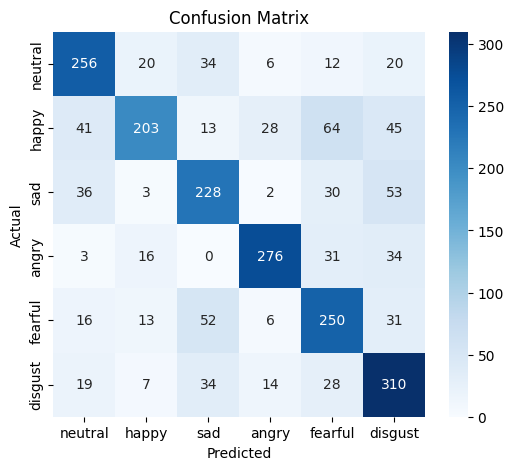

In [20]:

# ================================================================
# Evaluation
# ================================================================
model.load_state_dict(torch.load("best_model_per2.pth"))
model.eval()

all_preds, all_labels, all_preds2, all_labels2 = [], [], [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_preds2.append(torch.softmax(outputs, dim=1))
        all_labels.extend(y_batch.numpy())
        all_labels2.append(y_batch.to(device))

    val_preds = torch.cat(all_preds2)
    val_labels = torch.cat(all_labels2)
    val_auc = auroc(val_preds, val_labels).item()
    val_top3 = top3acc(val_preds, val_labels).item()

    y_pred = torch.argmax(val_preds, dim=1)

    accuracy = (y_pred == val_labels).float().mean()

    print(f"Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f} - top3_acc: {val_top3:.4f} - val_acc: {accuracy.item():.4f}")


# Classification report
class_labels = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']
report = classification_report(all_labels, all_preds, target_names=class_labels)
print(report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()